In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold ## for regression
from sklearn.model_selection import StratifiedKFold ## recommended for classification
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [3]:
test = pd.read_csv('option_test_wolabel.csv')
train = pd.read_csv('option_train.csv')

In [4]:
pd.read_csv('option_train.csv')

,Value,S,K,tau,r,BS
0,21.670404,431.623898,420.0,0.341270,0.03013,Under
1,0.125000,427.015526,465.0,0.166667,0.03126,Over
2,20.691244,427.762336,415.0,0.265873,0.03116,Under
3,1.035002,451.711658,460.0,0.063492,0.02972,Over
4,39.553020,446.718974,410.0,0.166667,0.02962,Under
...,...,...,...,...,...,...
1675,1.470000,444.397163,475.0,0.273810,0.03034,Over
1676,34.927317,438.453825,410.0,0.301587,0.02972,Under
1677,41.127997,428.042219,390.0,0.170635,0.03188,Under
1678,0.440003,439.081203,480.0,0.293651,0.02962,Over


In [5]:
train.describe()

,Value,S,K,tau,r
count,1679.000000,1679.000000,1678.000000,1679.000000,1680.000000
mean,15.072013,440.639445,438.241955,0.437519,0.030235
std,14.036492,13.130436,23.408989,7.057555,0.000557
min,0.125000,0.000000,375.000000,0.003968,0.029510
25%,2.255002,433.863864,420.000000,0.119048,0.029820
50%,11.220588,442.525366,440.000000,0.202381,0.030130
75%,25.745904,447.320414,455.000000,0.285714,0.030540
max,60.149367,455.880619,500.000000,250.000000,0.031880


In [6]:
train.isnull().sum()

Value    1
S        1
K        2
tau      1
r        0
BS       0
dtype: int64

In [7]:
train = train.dropna()

In [8]:
train.isnull().sum()

Value    0
S        0
K        0
tau      0
r        0
BS       0
dtype: int64

In [9]:
train['tau'].describe()

count    1678.000000
mean        0.437643
std         7.059657
min         0.003968
25%         0.119048
50%         0.202381
75%         0.285714
max       250.000000
Name: tau, dtype: float64

In [10]:
train['S'].sort_values()

879       0.000000
1316    425.472331
1147    425.472331
780     425.472331
835     425.472331
           ...    
871     455.880619
1259    455.880619
1571    455.880619
663     455.880619
1218    455.880619
Name: S, Length: 1678, dtype: float64

In [11]:
# drop rows with unreasonably high tau
train.drop(train[(train.tau > 1)].index, inplace = True)
# drop rows with 0 asset value
train.drop(train[(train.S == 0)].index, inplace = True)

In [12]:
train.shape

(1675, 6)

In [13]:
# BS: 1=over 0=under
train["BS"] = np.where(train["BS"] == 'Over', 1, 0)
train['difference'] = train['S']-train['K']
test['difference'] = test['S']-test['K']

In [14]:
train.index = range(1675)
train

,Value,S,K,tau,r,BS,difference
0,21.670404,431.623898,420.0,0.341270,0.03013,0,11.623898
1,0.125000,427.015526,465.0,0.166667,0.03126,1,-37.984474
2,20.691244,427.762336,415.0,0.265873,0.03116,0,12.762336
3,1.035002,451.711658,460.0,0.063492,0.02972,1,-8.288342
4,39.553020,446.718974,410.0,0.166667,0.02962,0,36.718974
...,...,...,...,...,...,...,...
1670,1.470000,444.397163,475.0,0.273810,0.03034,1,-30.602837
1671,34.927317,438.453825,410.0,0.301587,0.02972,0,28.453825
1672,41.127997,428.042219,390.0,0.170635,0.03188,0,38.042219
1673,0.440003,439.081203,480.0,0.293651,0.02962,1,-40.918797


In [15]:
X = train.drop(['Value','BS'], axis=1)
y1 = train.Value
y2 = train.BS

In [16]:
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X)
X_train_norm = pd.DataFrame(X_train_norm)

test_norm = mms.transform(test)
test_norm = pd.DataFrame(test_norm)

## Regression

In [17]:
kfolds_regresssion = KFold(n_splits = 10, random_state = 1, shuffle = True)

### Linear Regression

1 0.9163966987429778
2 0.9104968773238045
3 0.9108424075892363
4 0.902278609683183
5 0.9041371893562578
6 0.9081116845670857
7 0.9218792742069061
8 0.9221312010098512
9 0.9100407496599476
10 0.9077518829046837
Mean Score of Linear Regression: 0.9114066575043933


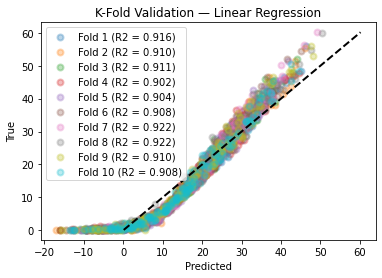

In [18]:
tot = 0
niter = 0
i = 1
for train_index, test_index in kfolds_regresssion.split(X_train_norm):
    X_train, X_test = X_train_norm.iloc[train_index], X_train_norm.iloc[test_index]
    y_train, y_test = y1.iloc[train_index], y1.iloc[test_index]

    model1 = LinearRegression()
    model1.fit(X_train, y_train)
    
    predictions = model1.predict(X_test)
    score = model1.score(X_test, y_test)
    tot += score
    niter += 1
    plt.scatter(predictions, y_test, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.3f)' % (i,score))
    i = i+1
    print(niter, score)
print(f'Mean Score of Linear Regression:', tot/niter)
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation — Linear Regression')
plt.legend()
plt.show()

### Decision Tree

1 0.9962397218699188
2 0.9973731431062196
3 0.9969594790839038
4 0.9963637408945852
5 0.9967409309632027
6 0.9972762364611922
7 0.9972018424900444
8 0.9970314275603932
9 0.9968056827127072
10 0.9957492041057355
Mean Score of Decision Tree Regression Model: 0.9967741409247901


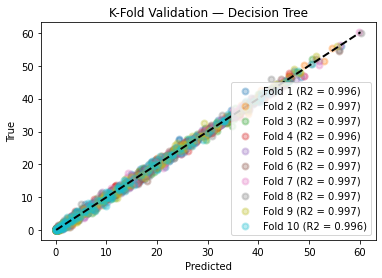

In [19]:
# Decision Tree
tot = 0
niter = 0
i = 1
for train_index, test_index in kfolds_regresssion.split(X_train_norm):
    X_train, X_test = X_train_norm.iloc[train_index], X_train_norm.iloc[test_index]
    y_train, y_test = y1.iloc[train_index], y1.iloc[test_index]
    
    model2 = DecisionTreeRegressor()
    model2.fit(X_train, y_train)
    
    predictions = model2.predict(X_test)
    score = model2.score(X_test, y_test)
    tot += score
    niter += 1
    plt.scatter(predictions, y_test, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.3f)' % (i,score))
    i = i+1
    print(niter, score)
print(f'Mean Score of Decision Tree Regression Model:', tot/niter)
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation — Decision Tree')
plt.legend()
plt.show()

### Random Forest

1 0.9978280900851676
2 0.9979083297639175
3 0.9978613946461248
4 0.9981468327297335
5 0.9977590671230436
6 0.9983252316955423
7 0.9979427376655242
8 0.9982235762749192
9 0.9978372178205998
10 0.9979323026944832
Mean Score of Random Forest Regression Model: 0.99798


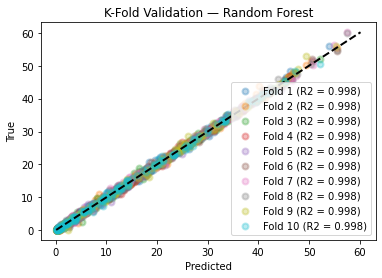

In [20]:
# Random Forest
tot = 0
niter = 0
i = 1
for train_index, test_index in kfolds_regresssion.split(X_train_norm):
    X_train, X_test = X_train_norm.iloc[train_index], X_train_norm.iloc[test_index]
    y_train, y_test = y1.iloc[train_index], y1.iloc[test_index]
    
    model3 = RandomForestRegressor(
        n_estimators=100, 
        max_depth=10, 
        max_features=3)
    model3.fit(X_train, y_train)
    
    predictions = model3.predict(X_test)
    score = model3.score(X_test, y_test)
    tot += score
    niter += 1
    plt.scatter(predictions, y_test, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.3f)' % (i,score))
    i = i+1
    print(niter, score)
print(f'Mean Score of Random Forest Regression Model:', round(tot/niter, 5))
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation — Random Forest')
plt.legend()
plt.show()

Text(0.5, 0, 'Random Forest Feature Importance')

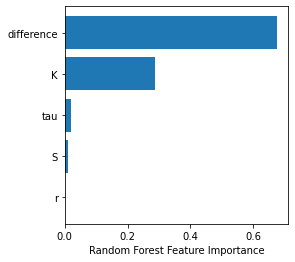

In [21]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4))
sorted_idx = model3.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model3.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Light Gradient Boosting Model

1 0.9981096771464
2 0.9975375992082138
3 0.9987079242453245
4 0.9991044959591617
5 0.9990848585459264
6 0.9987310400017855
7 0.9973624721880021
8 0.9975243012947617
9 0.9983135916717084
10 0.9987623258954854
Mean Score of Light Gradient Boosting Model: 0.99832


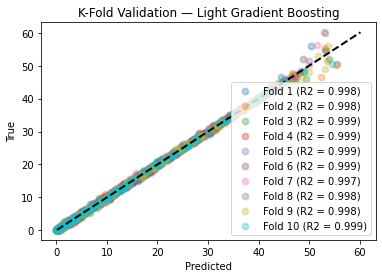

In [22]:
tot = 0
niter = 0
i = 1
for train_index, test_index in kfolds_regresssion.split(X_train_norm):
    X_train, X_test = X_train_norm.iloc[train_index], X_train_norm.iloc[test_index]
    y_train, y_test = y1.iloc[train_index], y1.iloc[test_index]
    
    model4 = lgb.LGBMRegressor(
        num_leaves=31,
        max_depth=10,
        learning_rate=0.1,
        n_estimators=200,
    )
    model4.fit(X_train, y_train)
    
    predictions = model4.predict(X_test)
    score = model4.score(X_test, y_test)
    tot += score
    niter += 1
    plt.scatter(predictions, y_test, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.3f)' % (i,score))
    i = i+1
    print(niter, score)
print(f'Mean Score of Light Gradient Boosting Model:', round(tot/niter, 5))
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation — Light Gradient Boosting')
plt.legend()
plt.show()

In [23]:
value_pred = model4.predict(test_norm)

In [24]:
model4.predict(test_norm)[:5]

array([ 1.21149765, 18.26470147, 10.62467395, 23.96290985, 16.16379973])

## Classification

### Logistic Regression

In [25]:
kfolds = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)

cv_classification_errors_1 = []
cv_auc_1 = []

for train_index, test_index in kfolds.split(train,train['BS']):
    # train the logistic model
    result = smf.logit('BS ~ S + K + tau + r + difference', 
                       data=train, subset = train_index).fit()
    # select the test set according to test_index produced by kfolds.split
    X_test = train.loc[test_index,["S","K",'tau','r','difference']]
    y_test = train.loc[test_index,"BS"]
    # compute the probabilities of test data
    result_prob = result.predict(X_test)
    # select 0.5 as the threshold
    result_pred = (result_prob > 0.5)
    # compute the classification error
    classification_error = np.mean(result_pred != y_test)
    # add the computed classification error to "cv_classification_errors_1" to
    # store the result
    cv_classification_errors_1.append(classification_error)
    
    # calculate the auc
    fpr,tpr,threshold = roc_curve(y_test, result_prob)
    roc_auc = auc(fpr,tpr)
    # add the computed auc to "cv_auc_1" to store the result
    cv_auc_1.append(roc_auc)
    
    
print("classification errors using 10-fold CV: {}\n".
      format(cv_classification_errors_1))
print("mean of classification errors using 10-fold CV: {}\n".
      format(np.mean(cv_classification_errors_1)))

         Current function value: 0.210854
         Iterations: 35
         Current function value: 0.207108
         Iterations: 35
         Current function value: 0.196174
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.212754
         Iterations 24
         Current function value: 0.206546
         Iterations: 35
         Current function value: 0.209525
         Iterations: 35
         Current function value: 0.215707
         Iterations: 35
         Current function value: 0.208084
         Iterations: 35
         Current function value: 0.202249
         Iterations: 35


C:\Users\yaoli\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yaoli\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yaoli\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yaoli\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yaoli\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

         Current function value: 0.207148
         Iterations: 35
classification errors using 10-fold CV: [0.09523809523809523, 0.06547619047619048, 0.1130952380952381, 0.06547619047619048, 0.08333333333333333, 0.09580838323353294, 0.04790419161676647, 0.08982035928143713, 0.10179640718562874, 0.09580838323353294]

mean of classification errors using 10-fold CV: 0.08537567721699459



C:\Users\yaoli\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Decision Tree

In [26]:
cv_classification_errors_1 = []
cv_auc_1 = []

for train_index, test_index in kfolds.split(train,train['BS']):
    # train the decision tree model
    result = DecisionTreeClassifier().fit(train.loc[train_index,["S","K",'tau','r','difference']], train.loc[train_index,"BS"])
    # select the test set according to test_index produced by kfolds.split
    X_test = train.loc[test_index,["S","K",'tau','r','difference']]
    y_test = train.loc[test_index,"BS"]
    # compute the probabilities of test data
    result_prob = result.predict(X_test)
    # select 0.5 as the threshold
    result_pred = (result_prob > 0.5)
    # compute the classification error
    classification_error = np.mean(result_pred != y_test)
    # add the computed classification error to "cv_classification_errors_1" to
    # store the result
    cv_classification_errors_1.append(classification_error)
    
    # calculate the auc
    fpr,tpr,threshold = roc_curve(y_test, result_prob)
    roc_auc = auc(fpr,tpr)
    # add the computed auc to "cv_auc_1" to store the result
    cv_auc_1.append(roc_auc)
    
    
print("classification errors using 10-fold CV: {}\n".
      format(cv_classification_errors_1))
print("mean of classification errors using 10-fold CV: {}\n".
      format(np.mean(cv_classification_errors_1)))

classification errors using 10-fold CV: [0.07738095238095238, 0.07142857142857142, 0.08928571428571429, 0.08333333333333333, 0.11904761904761904, 0.07784431137724551, 0.059880239520958084, 0.08383233532934131, 0.11377245508982035, 0.10179640718562874]

mean of classification errors using 10-fold CV: 0.08776019389791845



### KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier
cv_classification_errors_1 = []
cv_auc_1 = []

for train_index, test_index in kfolds.split(train,train['BS']):
    # train the knn model
    result = KNeighborsClassifier(n_neighbors = 10).fit(train.loc[train_index,["S","K",'tau','r','difference']], train.loc[train_index,"BS"])
    # select the test set according to test_index produced by kfolds.split
    X_test = train.loc[test_index,["S","K",'tau','r','difference']]
    y_test = train.loc[test_index,"BS"]
    # compute the probabilities of test data
    result_prob = result.predict(X_test)
    # select 0.5 as the threshold
    result_pred = (result_prob > 0.5)
    # compute the classification error
    classification_error = np.mean(result_pred != y_test)
    # add the computed classification error to "cv_classification_errors_1" to
    # store the result
    cv_classification_errors_1.append(classification_error)
    
    # calculate the auc
    fpr,tpr,threshold = roc_curve(y_test, result_prob)
    roc_auc = auc(fpr,tpr)
    # add the computed auc to "cv_auc_1" to store the result
    cv_auc_1.append(roc_auc)
    
    
print("classification errors using 10-fold CV: {}\n".
      format(cv_classification_errors_1))
print("mean of classification errors using 10-fold CV: {}\n".
       format(np.mean(cv_classification_errors_1)))

classification errors using 10-fold CV: [0.10119047619047619, 0.08928571428571429, 0.10714285714285714, 0.07738095238095238, 0.09523809523809523, 0.0718562874251497, 0.0718562874251497, 0.0658682634730539, 0.09580838323353294, 0.10179640718562874]

mean of classification errors using 10-fold CV: 0.08774237239806101



### Random Forest

In [28]:
cv_classification_errors_1 = []
cv_auc_1 = []

for train_index, test_index in kfolds.split(train,train['BS']):
    # train the random forest model
    result = RandomForestClassifier().fit(train.loc[train_index,["S","K",'tau','r','difference']], train.loc[train_index,"BS"])
    # select the test set according to test_index produced by kfolds.split
    X_test = train.loc[test_index,["S","K",'tau','r','difference']]
    y_test = train.loc[test_index,"BS"]
    # compute the probabilities of test data
    result_prob = result.predict(X_test)
    # select 0.5 as the threshold
    result_pred = (result_prob > 0.5)
    # compute the classification error
    classification_error = np.mean(result_pred != y_test)
    # add the computed classification error to "cv_classification_errors_1" to
    # store the result
    cv_classification_errors_1.append(classification_error)
    
    # calculate the auc
    fpr,tpr,threshold = roc_curve(y_test, result_prob)
    roc_auc = auc(fpr,tpr)
    # add the computed auc to "cv_auc_1" to store the result
    cv_auc_1.append(roc_auc)
    
    
print("classification errors using 10-fold CV: {}\n".
      format(cv_classification_errors_1))
print("mean of classification errors using 10-fold CV: {}\n".
      format(np.mean(cv_classification_errors_1)))

classification errors using 10-fold CV: [0.07142857142857142, 0.05952380952380952, 0.03571428571428571, 0.05952380952380952, 0.07142857142857142, 0.0658682634730539, 0.03592814371257485, 0.08383233532934131, 0.10179640718562874, 0.0718562874251497]

mean of classification errors using 10-fold CV: 0.06569004847447961



### SVM

In [29]:
from sklearn import svm
cv_classification_errors_1 = []
cv_auc_1 = []

for train_index, test_index in kfolds.split(train,train['BS']):
    # train the knn model
    result = svm.SVC().fit(train.loc[train_index,["S","K",'tau','r','difference']], train.loc[train_index,"BS"])
    # select the test set according to test_index produced by kfolds.split
    X_test = train.loc[test_index,["S","K",'tau','r','difference']]
    y_test = train.loc[test_index,"BS"]
    # compute the probabilities of test data
    result_prob = result.predict(X_test)
    # select 0.5 as the threshold
    result_pred = (result_prob > 0.5)
    # compute the classification error
    classification_error = np.mean(result_pred != y_test)
    # add the computed classification error to "cv_classification_errors_1" to
    # store the result
    cv_classification_errors_1.append(classification_error)
    
    # calculate the auc
    fpr,tpr,threshold = roc_curve(y_test, result_prob)
    roc_auc = auc(fpr,tpr)
    # add the computed auc to "cv_auc_1" to store the result
    cv_auc_1.append(roc_auc)

print("classification errors using 10-fold CV: {}\n".
      format(cv_classification_errors_1))
print("mean of classification errors using 10-fold CV: {}\n".
       format(np.mean(cv_classification_errors_1)))

classification errors using 10-fold CV: [0.08333333333333333, 0.07738095238095238, 0.1130952380952381, 0.07738095238095238, 0.09523809523809523, 0.10179640718562874, 0.05389221556886228, 0.08982035928143713, 0.10179640718562874, 0.10778443113772455]

mean of classification errors using 10-fold CV: 0.09015183917878529



### Light Gradient Boosted Tree

In [30]:
from sklearn import svm
cv_classification_errors_1 = []
cv_auc_1 = []

for train_index, test_index in kfolds.split(train,train['BS']):
    # train the knn model
    result = lgb.LGBMRegressor().fit(train.loc[train_index,["S","K",'tau','r','difference']], train.loc[train_index,"BS"])
    # select the test set according to test_index produced by kfolds.split
    X_test = train.loc[test_index,["S","K",'tau','r','difference']]
    y_test = train.loc[test_index,"BS"]
    # compute the probabilities of test data
    result_prob = result.predict(X_test)
    # select 0.5 as the threshold
    result_pred = (result_prob > 0.5)
    # compute the classification error
    classification_error = np.mean(result_pred != y_test)
    # add the computed classification error to "cv_classification_errors_1" to
    # store the result
    cv_classification_errors_1.append(classification_error)
    
    # calculate the auc
    fpr,tpr,threshold = roc_curve(y_test, result_prob)
    roc_auc = auc(fpr,tpr)
    # add the computed auc to "cv_auc_1" to store the result
    cv_auc_1.append(roc_auc)

print("classification errors using 10-fold CV: {}\n".
      format(cv_classification_errors_1))
print("mean of classification errors using 10-fold CV: {}\n".
       format(np.mean(cv_classification_errors_1)))

classification errors using 10-fold CV: [0.08928571428571429, 0.06547619047619048, 0.041666666666666664, 0.05357142857142857, 0.05952380952380952, 0.05389221556886228, 0.04790419161676647, 0.07784431137724551, 0.09580838323353294, 0.0718562874251497]

mean of classification errors using 10-fold CV: 0.06568291987453664



In [31]:
final_result = lgb.LGBMRegressor().fit(train[["S","K",'tau','r','difference']], train["BS"].ravel())
BS_pred = final_result.predict(test)

In [32]:
BS_pred

array([ 0.9731984 , -0.00882819,  0.04254516, ...,  0.99703311,
       -0.06728244,  0.08700918])

In [33]:
pd.DataFrame([value_pred, BS_pred]).transpose().rename(columns={0:'value_pred', 1:'BS_pred'}).to_csv('pred.csv')